In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, torch

## format data

In [9]:
np.random.seed(0)

div_pos = .0

N = 50000
stim_pos = np.random.uniform(-0.38, 0.38, N)
noise_std = 0.05

X_np = stim_pos + np.random.normal(0, noise_std, N)
Y_np = stim_pos + np.random.normal(0, noise_std, N)
labels_np = (X_np > 0).astype(float)

# convert to pytorch tensors
X = torch.from_numpy(X_np).float().unsqueeze(1)      # shape (N,1)
Y = torch.from_numpy(Y_np).float().unsqueeze(1)
labels = torch.from_numpy(labels_np).float().unsqueeze(1)

## setup model

In [10]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)   # single scalar output
)

from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

# Hyperparameters
divider_position = 0.0
boundary_width   = 0.1
learning_rate    = 1e-2
batch_size       = 128
num_epochs       = 50

# Prepare data loader
dataset    = TensorDataset(X, Y, labels)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Optimizer & history
optimizer = Adam(model.parameters(), lr=learning_rate)
history = {'mse': [], 'bce': [], 'total': [], 'accuracy': []}

## training

In [11]:
for epoch in range(num_epochs):
    epoch_mse      = 0.0
    epoch_bce      = 0.0
    epoch_accuracy = 0.0
    epoch_total    = 0.0

    for inputs, targets, class_labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute per-sample weight based on distance to divider
        distance_from_divider = torch.abs(inputs - divider_position)
        classification_weight = torch.exp(-distance_from_divider / boundary_width)
        classification_weight = .1

        # Per-sample losses
        per_sample_mse = (outputs - targets).pow(2)
        per_sample_bce = F.binary_cross_entropy_with_logits(
            outputs, class_labels, reduction='none'
        )

        # Combine losses with distance-based weighting
        batch_loss = ((1 - classification_weight) * per_sample_mse
                      + classification_weight * per_sample_bce).mean()
        batch_loss.backward()
        optimizer.step()

        # Accumulate for logging
        epoch_mse      += per_sample_mse.mean().item()
        epoch_bce      += per_sample_bce.mean().item()
        epoch_total    += batch_loss.item()
        epoch_accuracy += (
            outputs.sigmoid().gt(0.5) == class_labels
        ).float().mean().item()

    num_batches = len(data_loader)
    history['mse'].append(epoch_mse / num_batches)
    history['bce'].append(epoch_bce / num_batches)
    history['total'].append(epoch_total / num_batches)
    history['accuracy'].append(epoch_accuracy / num_batches)

# Final predictions on the full dataset
with torch.no_grad():
    final_outputs      = model(X)
    y_predictions      = final_outputs.squeeze().numpy()
    class_predictions  = (final_outputs.sigmoid().squeeze().numpy() > 0.5).astype(int)


## collate data

In [12]:
df = pd.DataFrame({
    'X':            X_np[:1000],
    'Y_true':      Y_np[:1000],
    'Y_pred':      y_predictions[:1000],
    'class_pred':  class_predictions[:1000],
    'class_true':  labels_np[:1000].astype(int),
})
print(df.head())

          X    Y_true    Y_pred  class_pred  class_true
0  0.017845 -0.020495  0.036288           1           1
1  0.155088  0.129901  0.187982           1           1
2  0.037651 -0.002996  0.068249           1           1
3  0.078212  0.049931  0.110926           1           1
4 -0.043777 -0.094465 -0.062557           0           0


## plot loss curves

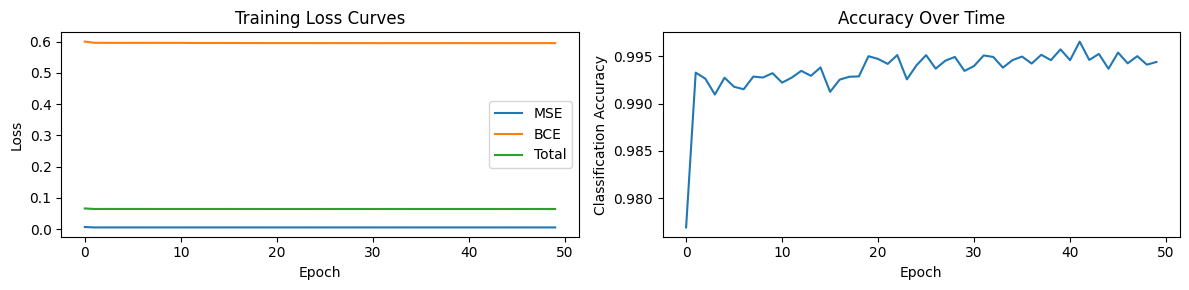

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

axs[0].plot(history['mse'], label='MSE')
axs[0].plot(history['bce'], label='BCE')
axs[0].plot(history['total'], label='Total')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss Curves')

axs[1].plot(history['accuracy'], label='Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Classification Accuracy')
axs[1].set_title('Accuracy Over Time')

plt.tight_layout()
plt.show()


## viz behavior

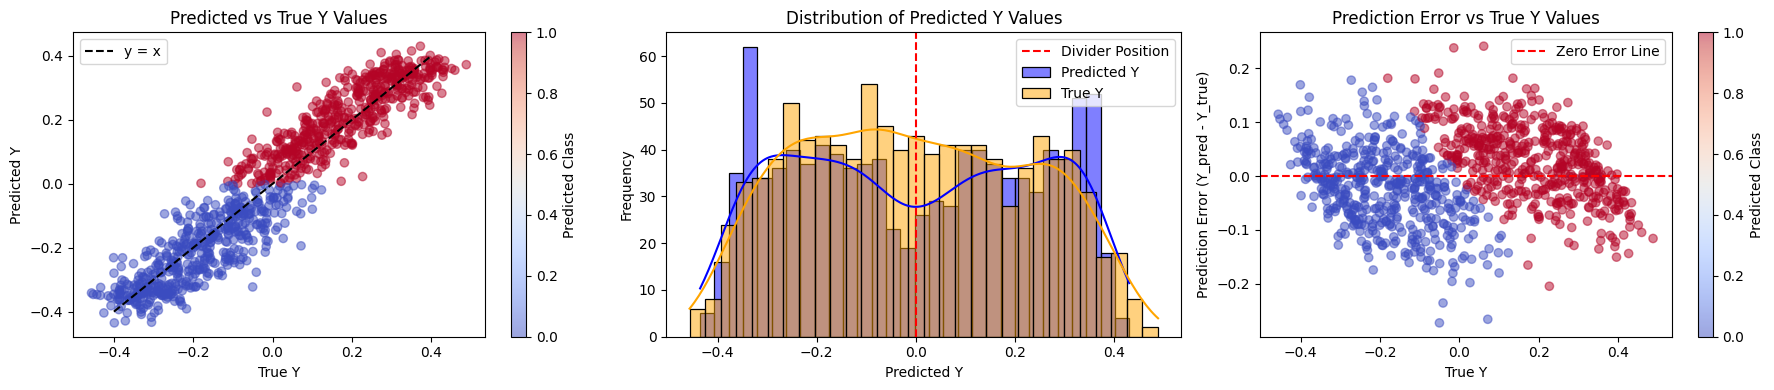

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# y_pred vs y_true
sc1 = axs[0].scatter(df['Y_true'], df['Y_pred'], c=df['class_pred'], cmap='coolwarm', alpha=0.5)
axs[0].plot([-0.4, 0.4], [-0.4, 0.4], 'k--', label='y = x')
axs[0].set_xlabel('True Y')
axs[0].set_ylabel('Predicted Y')
axs[0].set_title('Predicted vs True Y Values')
fig.colorbar(sc1, ax=axs[0], label='Predicted Class')
axs[0].legend()

# dist of y_pred
sns.histplot(df['Y_pred'], bins=30, kde=True, color='blue', label='Predicted Y', ax=axs[1])
sns.histplot(df['Y_true'], bins=30, kde=True, color='orange', label='True Y', ax=axs[1], alpha=0.5)
axs[1].axvline(x=0, color='red', linestyle='--', label='Divider Position')
axs[1].set_xlabel('Predicted Y')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Predicted Y Values')
axs[1].legend()

# y_pred - y_true vs y_true
sc2 = axs[2].scatter(df['Y_true'], df['Y_pred'] - df['Y_true'], c=df['class_pred'], cmap='coolwarm', alpha=0.5)
axs[2].axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
axs[2].set_xlabel('True Y')
axs[2].set_ylabel('Prediction Error (Y_pred - Y_true)')
axs[2].set_title('Prediction Error vs True Y Values')
fig.colorbar(sc2, ax=axs[2], label='Predicted Class')
axs[2].legend()

plt.tight_layout()
plt.show()

## viz embeddings

## scratch

In [15]:
stim = np.random.uniform(-0.38, 0.38, 50000)
x = np.sort(stim)

In [16]:
N = 50_000
n = np.arange(N)

# Hann window runs 0→1→0 smoothly
hann = 0.5 * (1 - np.cos(2 * np.pi * n / (N - 1)))

# scale peak to 0.4
vals = 0.4 * hann
noise = vals

In [17]:
y = x + noise

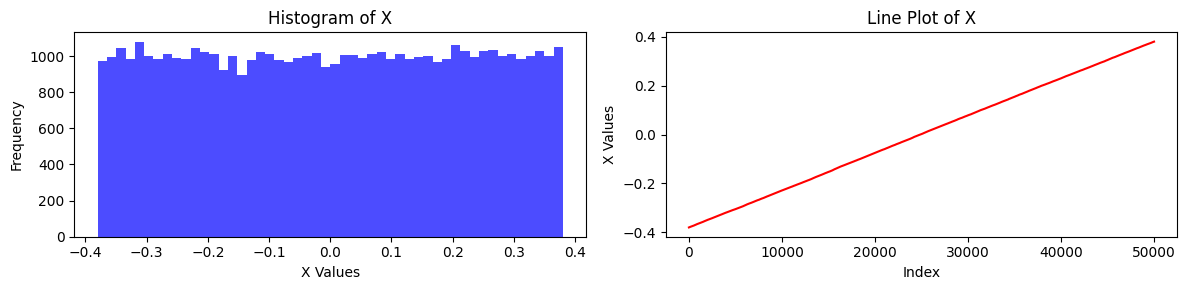

In [18]:
# subplot in 1 row hist and plt.plot of X
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(x, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Histogram of X')
axs[0].set_xlabel('X Values')
axs[0].set_ylabel('Frequency')

axs[1].plot(x, color='red')
axs[1].set_title('Line Plot of X')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('X Values')   
plt.tight_layout()
plt.show()

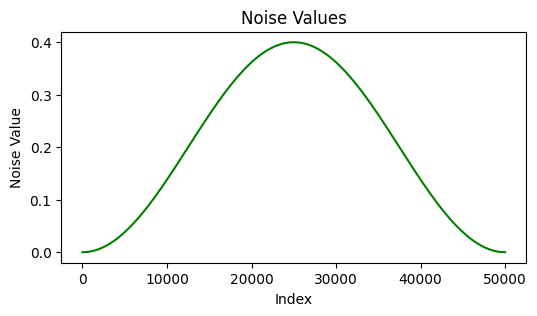

In [19]:
# plot the noise
plt.figure(figsize=(6, 3))
plt.plot(noise, color='green')
plt.title('Noise Values')
plt.xlabel('Index')
plt.ylabel('Noise Value')
plt.show()

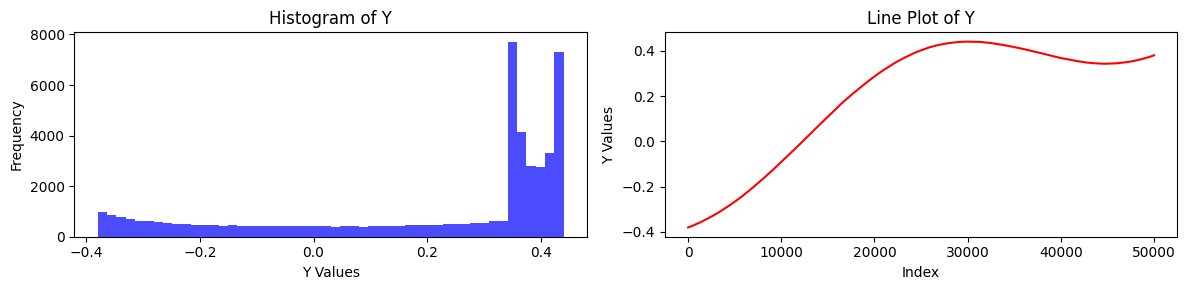

In [20]:
# plot in 1 line using subplot the dist of y and y itself
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(y, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Y')
axs[0].set_xlabel('Y Values')
axs[0].set_ylabel('Frequency')

axs[1].plot(y, color='red')
axs[1].set_title('Line Plot of Y')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Y Values')
plt.tight_layout()
plt.show()